# Data Exploration and Pre-Processing

## 1 Investigation

In [2]:
import os
import nibabel as nib
import gzip
from PIL import Image

# get notebook path
path = os.path.abspath('')
path = path.split('/')
path = '/'.join(path[:-1])
print(path)

def read_image(file_path):
    nii_img = nib.load(file_path)
    image_data = nii_img.get_fdata()
    header = nii_img.header
    return image_data, header

In [3]:
image_data, _ = read_image(os.path.join(path, 'data_dev/data_dev/train/images/RibFrac421-image.nii.gz'))
label_data, header = read_image(os.path.join(path, 'data_dev/data_dev/train/labels/RibFrac421-label.nii.gz'))

MemoryError: 

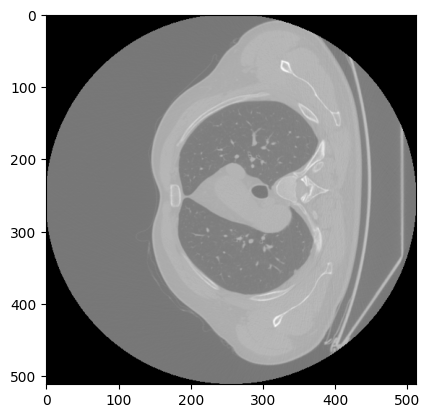

MemoryError: Unable to allocate 650. MiB for an array with shape (512, 512, 325) and data type float64

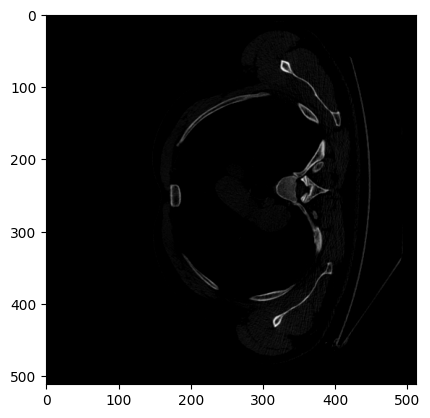

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imagerelu(x):
    return np.where(np.asarray(x) > 0, x, 0)

# plot the image
plt.imshow(image_data[:,:,240], cmap='gray')
plt.show()

# plot transformed image
plt.imshow(imagerelu(image_data[:,:,240]), cmap='gray')

image_data = imagerelu(image_data)


In [ ]:
print(label_data.shape)
print(header)

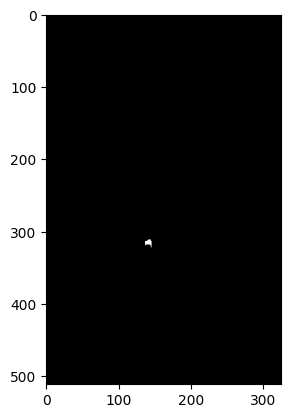

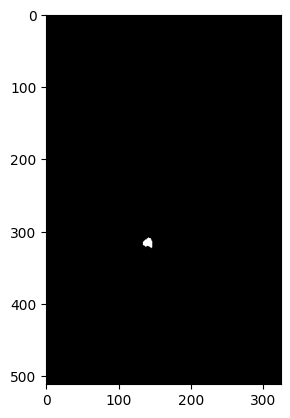

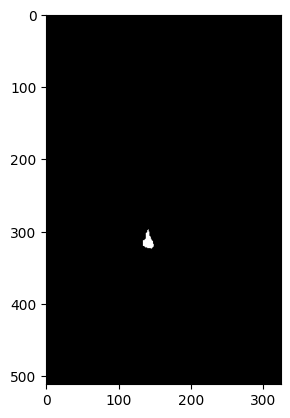

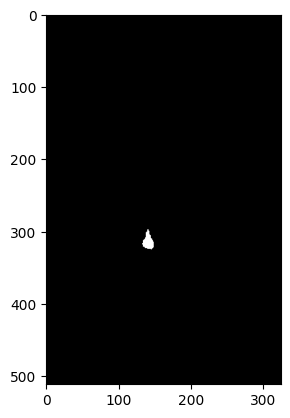

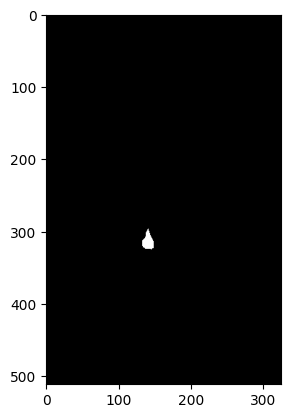

In [5]:
# plot the slices with annotation
count = 0
for slice in label_data:
    if slice.sum() > 0:
        plt.imshow(slice, cmap="gray")
        plt.show()
        count += 1
        if count == 5:
            break

## 2 Pre-Processing

### Making them all the same shape

I do not hink this is a good approach because it adds latency to the data loading.
We should rather downsample the 3rd dimension.
Maybe after downsampling apply this function.

In [ ]:
import numpy as np
from tqdm import tqdm as tqmd

override = False
mode = 'val' # 'train', 'val', 'test'

# find image with the most slices in 3rd dimension
max_slices = 0
print("finding largest file...")
for file in tqmd(os.listdir(os.path.join(path, f'data/ribfrac-{mode}-images'))):
    image_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-images', file))
    if image_data.shape[2] > max_slices:
        max_slices = image_data.shape[2]
        max_slices_file = file
print("largest file, size:", max_slices_file, max_slices)

# make a new folder to store the preprocessed data
if not os.path.exists(os.path.join(path, 'data/preprocessed')):
    os.makedirs(os.path.join(path, 'data/preprocessed'))
if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images')):
    os.makedirs(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images'))
if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels')):
    os.makedirs(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels'))

# pad all images to the same size
print("pre-processing images...")
for file in tqmd(os.listdir(os.path.join(path, f'data/ribfrac-{mode}-images'))):
    # check if file has been processed
    if not os.path.exists(os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images', file)):
        image_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-images', file))
        label_data, _ = read_image(os.path.join(path, f'data/ribfrac-{mode}-labels', file.replace('image', 'label')))
        if image_data.shape[2] < max_slices:
            image_data = np.pad(image_data, ((0, 0), (0, 0), (0, max_slices - image_data.shape[2])), 'constant')
            label_data = np.pad(label_data, ((0, 0), (0, 0), (0, max_slices - label_data.shape[2])), 'constant')
            nib.save(
                nib.Nifti1Image(image_data, np.eye(4)),
                os.path.join(path, f'data/preprocessed/ribfrac-{mode}-images', file)
                )
            nib.save(
                nib.Nifti1Image(label_data, np.eye(4)),
                os.path.join(path, f'data/preprocessed/ribfrac-{mode}-labels', file.replace('image', 'label'))
                )

### Make labels all 1 instead of 1, 2, 3, 4, -1